# Cloud Service Scoring Evaluation

This notebook provides a comprehensive evaluation framework for analyzing Cloud Elevation Index (CEI) scores generated by different AI models. It includes:

- **Model Comparison**: Compare scores between Gemini 1.5 Pro and Gemini 2.0 Flash
- **Ground Truth Validation**: Validate against known service categories
- **Anomaly Detection**: Identify statistical outliers
- **Visualizations**: Interactive plots and charts
- **Comprehensive Reporting**: Generate detailed evaluation reports

## 1. Import Required Libraries

First, let's import all the necessary libraries for data processing, analysis, and visualization.

In [1]:
import json
import pandas as pd
import numpy as np
from typing import Dict, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Import our custom utils functions
from utils import (
    load_old_format_scores,
    load_new_format_scores,
    compare_model_scores_unified,
    validate_dataframe_against_ground_truth,
    export_comparison_results_to_file
)


## 2. Load Ground Truth Data

Load ground truth services with expected score ranges from the configuration file.

**File Structure:**
- Configuration files: `config/` directory (prompts, ground truth, input data)
- Score results: `scores/` directory (all scoring outputs and logs)
- Utilities: `utils/` directory (reusable analysis functions)

In [2]:
# Load ground truth data from JSON file in config directory
with open('config/ground_truth.json', 'r') as f:
    config = json.load(f)
    ground_truth = config['ground_truth']

# Convert list ranges back to tuples for compatibility
for service_name, service_data in ground_truth.items():
    service_data['expected_range'] = tuple(service_data['expected_range'])

print(f"Loaded ground truth data for {len(ground_truth)} services")
print("Categories:", set(data['category'] for data in ground_truth.values()))

Loaded ground truth data for 13 services
Categories: {'PaaS', 'IaaS', 'High-PaaS/SaaS', 'SaaS'}


## 3. Score Data Loading and Comparison

The utility functions for loading different NDJSON formats and performing cross-model score comparisons are now imported from the utils package.

In [3]:
# Example: Load different format files and compare scores
import os

# Check available data files in both config and scores directories
config_files = [f"config/{f}" for f in os.listdir('config') if f.endswith('.ndjson')]
scores_files = [f"scores/{f}" for f in os.listdir('scores') if f.endswith('.ndjson')]
available_files = config_files + scores_files

print("Available NDJSON files:")
print("  Config files:", [f for f in config_files])
print("  Score files:", [f for f in scores_files])

# Example loading different formats
dataframes_to_compare = []

# Load old format files (typically in scores directory)
old_format_files = ['scores/cei_scores.ndjson']  # Add your old format files here
for file in old_format_files:
    if os.path.exists(file):
        print(f"Loading old format file: {file}")
        df_old = load_old_format_scores(file)
        print(f"  - Loaded {len(df_old)} services")
        print(f"  - Score columns: {[col for col in df_old.columns if 'score' in col.lower()]}")
        dataframes_to_compare.append(df_old)

# Load new format files (typically in scores directory)
new_format_files = ['scores/2025-09-15-15-43-15-claude-3-5.ndjson']  # Add your new format files here
for file in new_format_files:
    if os.path.exists(file):
        print(f"Loading new format file: {file}")
        df_new = load_new_format_scores(file)
        print(f"  - Loaded {len(df_new)} services")
        print(f"  - Score columns: {[col for col in df_new.columns if 'score' in col.lower()]}")
        dataframes_to_compare.append(df_new)

Available NDJSON files:
  Config files: ['config/extracted_services.ndjson']
  Score files: ['scores/2025-09-15-15-43-15-claude-3-5.ndjson', 'scores/cei_scores.ndjson']
Loading old format file: scores/cei_scores.ndjson
  - Loaded 623 services
  - Score columns: ['score', 'gemini_1_5_pro_score', 'gemini_2_0_flash_score', 'avg_gemini_score']
Loading new format file: scores/2025-09-15-15-43-15-claude-3-5.ndjson
  - Loaded 623 services
  - Score columns: ['claude_3_5_score']


In [4]:
# Example: Validate individual dataframes against ground truth
print("\n=== GROUND TRUTH VALIDATION ===")

# Validate each loaded dataframe against ground truth
for i, df in enumerate(dataframes_to_compare):
    print(f"\nValidating Dataset {i+1}:")
    
    # Run ground truth validation
    validation_results = validate_dataframe_against_ground_truth(df, ground_truth)
    
    if 'error' in validation_results:
        print(f"Error: {validation_results['error']}")
        continue
    
    # Display summary
    summary = validation_results['validation_summary']
    print(f"  Score columns analyzed: {', '.join(validation_results['score_columns_analyzed'])}")
    print(f"  Services found in data: {summary['services_found_in_data']}/{summary['total_services_in_ground_truth']}")
    print(f"  Services within expected range: {summary['services_within_expected_range']}")
    print(f"  Services outside expected range: {summary['services_outside_expected_range']}")
    print(f"  Accuracy rate: {summary['accuracy_rate']:.2%}")
    
    # Show services that don't meet ground truth (outside expected range)
    if validation_results['services_outside_range']:
        print(f"\n  === SERVICES OUTSIDE EXPECTED RANGE ===")
        for j, service in enumerate(validation_results['services_outside_range'][:5], 1):  # Show top 5
            print(f"  {j}. {service['service_name']} ({service['provider']})")
            print(f"     Expected ({service['expected_category']}): {service['expected_range']}")
            for score_col, analysis in service['scores_analysis'].items():
                print(f"     {score_col}: {analysis['actual_score']:.2f} (deviation: {analysis['deviation_from_range']:.2f})")
            print()
    
    # Show services not found in data
    if validation_results['services_not_found']:
        print(f"  === SERVICES NOT FOUND IN DATA ===")
        for service in validation_results['services_not_found'][:3]:  # Show first 3
            print(f"  - {service['service_name']} ({service['provider']}) - Expected: {service['expected_category']}")
    
    print("-" * 60)


=== GROUND TRUTH VALIDATION ===

Validating Dataset 1:
  Score columns analyzed: score, gemini_1_5_pro_score, gemini_2_0_flash_score, avg_gemini_score
  Services found in data: 13/13
  Services within expected range: 13
  Services outside expected range: 0
  Accuracy rate: 100.00%
------------------------------------------------------------

Validating Dataset 2:
  Score columns analyzed: claude_3_5_score
  Services found in data: 13/13
  Services within expected range: 13
  Services outside expected range: 0
  Accuracy rate: 100.00%
------------------------------------------------------------


## 4. Usage: Loading and Comparing Multiple Score Files

Examples of how to use the imported utility functions with different data formats.

In [5]:
# Available score columns in your data:
print("=== AVAILABLE SCORE COLUMNS ===")
all_available_columns = set()
for i, df in enumerate(dataframes_to_compare):
    score_cols = [col for col in df.columns if 'score' in col.lower()]
    print(f"Dataset {i+1}: {score_cols}")
    all_available_columns.update(score_cols)

print(f"\nAll unique score columns: {sorted(list(all_available_columns))}")

=== AVAILABLE SCORE COLUMNS ===
Dataset 1: ['score', 'gemini_1_5_pro_score', 'gemini_2_0_flash_score', 'avg_gemini_score']
Dataset 2: ['claude_3_5_score']

All unique score columns: ['avg_gemini_score', 'claude_3_5_score', 'gemini_1_5_pro_score', 'gemini_2_0_flash_score', 'score']


In [6]:
# CUSTOMIZE THIS: Specify which columns you want to compare
# Example options:
# columns_to_compare = ['claude_simple_score', 'gemini_1_5_pro_score']
# columns_to_compare = ['cei_score', 'claude_simple_score'] 
# columns_to_compare = None  # Compare all available columns

columns_to_compare = ['claude_3_5_score','gemini_1_5_pro_score', 'gemini_2_0_flash_score']  # Modify this list as needed

In [10]:
# Run comparison analysis if we have data to compare
if len(dataframes_to_compare) >= 2:
    print(f"\n=== RUNNING COMPARISON ANALYSIS ===")
    print(f"Comparing {len(dataframes_to_compare)} datasets")

    if 'columns_to_compare' not in locals() or columns_to_compare is None:
        columns_to_compare = None  # Will use all available score columns
        print("Using all available score columns for comparison")
    else:
        print(f"Using specified columns for comparison: {columns_to_compare}")
    
    # Run comparison with configurable thresholds
    comparison_results = compare_model_scores_unified(
        dataframes=dataframes_to_compare,
        disagreement_threshold=2.0,  # Configurable threshold
        show_similar=True,           # Set to True to see similar services too
        similarity_threshold=1,    # Configurable similarity threshold
        columns_to_compare=columns_to_compare  # Specify which columns to compare
    )
    
    # Check for errors
    if 'error' in comparison_results:
        print(f"❌ Error: {comparison_results['error']}")
    else:
        # Display results
        print(f"\n=== ANALYSIS SUMMARY ===")
        summary = comparison_results['analysis_summary']
        print(f"Total services compared: {summary['total_services_compared']}")
        print(f"Score columns analyzed: {', '.join(comparison_results['score_columns_analyzed'])}")
        print(f"Services with high disagreement: {summary['services_with_high_disagreement']}")
        print(f"Services with high similarity: {summary['services_with_high_similarity']}")
        
        # Show high disagreement services
        print(f"\n=== HIGH DISAGREEMENT SERVICES (deviation > {comparison_results['disagreement_threshold']}) ===")
        for i, service in enumerate(comparison_results['high_disagreement_services'][:10], 1):  # Show top 10
            print(f"{i}. {service['service_name']} ({service['provider']})")
            print(f"   Median Score: {service['median_score']:.2f}")
            print(f"   Max Deviation: {service['max_deviation']:.2f}")
            print(f"   Scores: {', '.join([f'{k}={v:.2f}' for k, v in service['scores'].items()])}")
            print(f"   Deviations: {', '.join([f'{k}={v:.2f}' for k, v in service['deviations'].items()])}")
            print()
        
        # Show high similarity services (if requested)
        if comparison_results['high_similarity_services']:
            print(f"\n=== HIGH SIMILARITY SERVICES (deviation <= {comparison_results['similarity_threshold']}) ===")
            for i, service in enumerate(comparison_results['high_similarity_services'][:5], 1):  # Show top 5
                print(f"{i}. {service['service_name']} ({service['provider']})")
                print(f"   Median Score: {service['median_score']:.2f}")
                print(f"   Max Deviation: {service['max_deviation']:.2f}")
                print(f"   Scores: {', '.join([f'{k}={v:.2f}' for k, v in service['scores'].items()])}")
                print()
        
        # Export all results to text file
        print(f"\n=== EXPORTING RESULTS ===")
        exported_file = export_comparison_results_to_file(comparison_results)
        if exported_file:
            print(f"Complete analysis exported to: {exported_file}")
            print("This file contains ALL services that meet the criteria, not just the top ones shown above.")

else:
    print("Need at least 2 datasets to run comparison analysis")
    print("Please ensure you have the appropriate NDJSON files in the current directory")


=== RUNNING COMPARISON ANALYSIS ===
Comparing 2 datasets
Using specified columns for comparison: ['claude_3_5_score', 'gemini_1_5_pro_score', 'gemini_2_0_flash_score']

=== ANALYSIS SUMMARY ===
Total services compared: 623
Score columns analyzed: claude_3_5_score, gemini_1_5_pro_score, gemini_2_0_flash_score
Services with high disagreement: 41
Services with high similarity: 389

=== HIGH DISAGREEMENT SERVICES (deviation > 2.0) ===
1. Enterprise Agreement (GCP)
   Median Score: 9.18
   Max Deviation: 8.18
   Scores: claude_3_5_score=9.18, gemini_1_5_pro_score=1.00, gemini_2_0_flash_score=10.00
   Deviations: claude_3_5_score=0.00, gemini_1_5_pro_score=8.18, gemini_2_0_flash_score=0.82

2. SnowballExtraDays (AWS)
   Median Score: 8.86
   Max Deviation: 7.43
   Scores: claude_3_5_score=9.00, gemini_1_5_pro_score=1.43, gemini_2_0_flash_score=8.86
   Deviations: claude_3_5_score=0.14, gemini_1_5_pro_score=7.43, gemini_2_0_flash_score=0.00

3. Cloud Vision OCR On-Prem (GCP)
   Median Score:

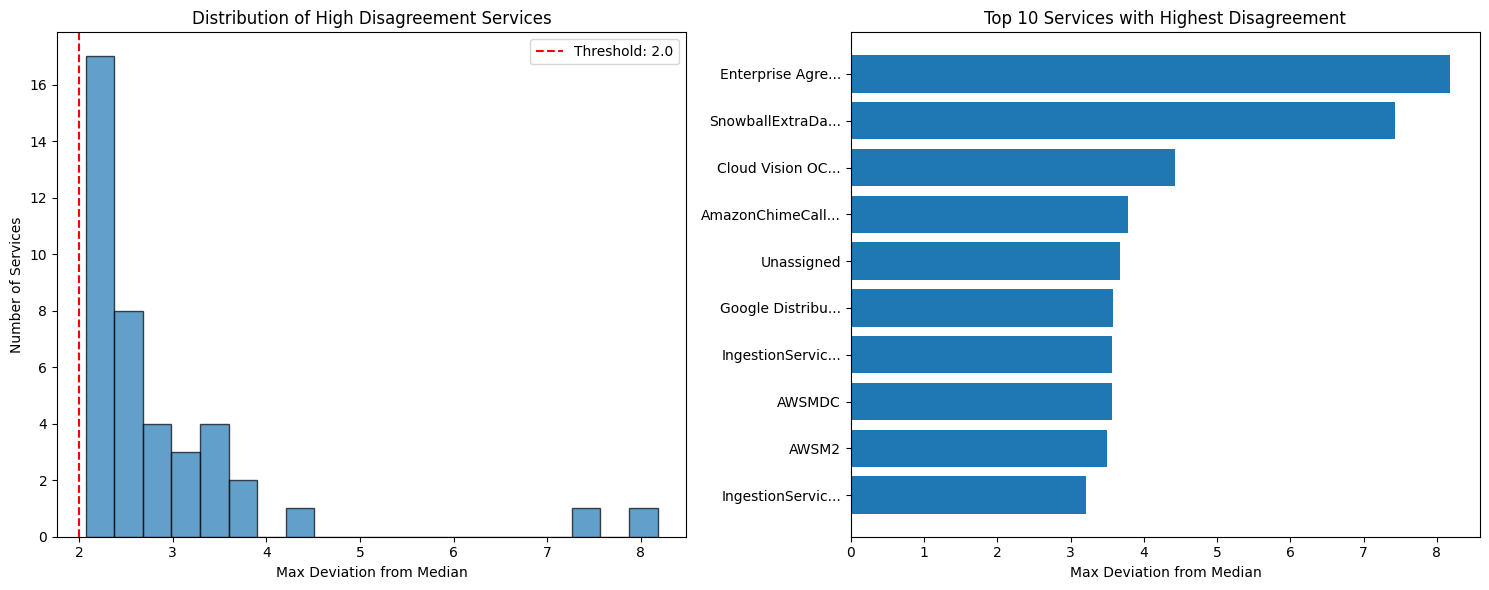

In [8]:
# Optional: Visualize disagreement analysis
def visualize_disagreement_analysis(comparison_results):
    """Create visualizations for the disagreement analysis."""
    if 'error' in comparison_results:
        print("Cannot create visualizations:", comparison_results['error'])
        return
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # 1. Disagreement distribution
    disagreement_services = comparison_results['high_disagreement_services']
    if disagreement_services:
        max_deviations = [s['max_deviation'] for s in disagreement_services]
        axes[0].hist(max_deviations, bins=20, edgecolor='black', alpha=0.7)
        axes[0].axvline(comparison_results['disagreement_threshold'], 
                       color='red', linestyle='--', 
                       label=f'Threshold: {comparison_results["disagreement_threshold"]}')
        axes[0].set_xlabel('Max Deviation from Median')
        axes[0].set_ylabel('Number of Services')
        axes[0].set_title('Distribution of High Disagreement Services')
        axes[0].legend()
    
    # 2. Top disagreement services
    if len(disagreement_services) >= 10:
        top_services = disagreement_services[:10]
        service_names = [s['service_name'][:15] + '...' if len(s['service_name']) > 15 
                        else s['service_name'] for s in top_services]
        deviations = [s['max_deviation'] for s in top_services]
        
        axes[1].barh(range(len(service_names)), deviations)
        axes[1].set_yticks(range(len(service_names)))
        axes[1].set_yticklabels(service_names)
        axes[1].set_xlabel('Max Deviation from Median')
        axes[1].set_title('Top 10 Services with Highest Disagreement')
        axes[1].invert_yaxis()
    
    plt.tight_layout()
    plt.show()

# Create visualization if we have comparison results
if 'comparison_results' in locals():
    visualize_disagreement_analysis(comparison_results)